In [2]:
from torch import nn
import torch
from torchvision.transforms import v2
from torchvision.models import efficientnet_v2_s,get_model_weights,EfficientNet_V2_S_Weights,resnet50,ResNet50_Weights,ViT_B_16_Weights,vit_b_16
from torchvision import datasets
import torch.optim as optim
import os
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tempfile import TemporaryDirectory
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
list(get_model_weights(efficientnet_v2_s))

[EfficientNet_V2_S_Weights.IMAGENET1K_V1]

In [3]:
model = efficientnet_v2_s(weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1)

In [4]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [5]:
model.classifier[1] = nn.Linear(in_features=1280, out_features=14, bias=True) 

In [6]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
data_transforms = {
    'train': v2.Compose([
        v2.Resize(384),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': v2.Compose([
        v2.Resize(384),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.Resize(384),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './splits'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test','val']}


In [19]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 127545
     Root location: ./splits/train
     StandardTransform
 Transform: Compose(
                  Resize(size=[384], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToTensor()
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 25521
     Root location: ./splits/test
     StandardTransform
 Transform: Compose(
                  Resize(size=[384], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToTensor()
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 17001
     Root location: ./splits/val
     StandardTransform
 Transform: Compose(
                  Resize(size=[384], interpolation=InterpolationMode.BILINEAR, antialias=True)
          

In [20]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=1)
               for x in ['train', 'test','val']}


In [21]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', "test",'val']}

In [22]:
dataset_sizes

{'train': 127545, 'test': 25521, 'val': 17001}

In [23]:
class_names = image_datasets['train'].classes

In [24]:
class_names

['ART',
 'BLA',
 'EBO',
 'EOS',
 'LYT',
 'MMZ',
 'MON',
 'MYB',
 'NGB',
 'NGS',
 'NIF',
 'PEB',
 'PLM',
 'PMO']

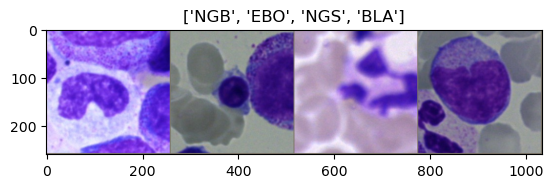

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
len(class_names)

14

In [15]:
device = torch.device("mps")
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to("mps")
                    labels = labels.to("mps")

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    #scheduler.step()
                    pass

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = float(running_corrects)/ dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=2e-4)
exp_lr_scheduler = None
model = model.to("mps")
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


100%|██████████| 31887/31887 [2:04:44<00:00,  4.26it/s]  


train Loss: 0.6600 Acc: 0.7885


100%|██████████| 4251/4251 [02:16<00:00, 31.06it/s]


val Loss: 0.5014 Acc: 0.8378

Epoch 1/1
----------


100%|██████████| 31887/31887 [2:05:11<00:00,  4.25it/s]  


train Loss: 0.5067 Acc: 0.8341


100%|██████████| 4251/4251 [02:13<00:00, 31.77it/s]


val Loss: 0.5841 Acc: 0.8427

Training complete in 254m 28s
Best val Acc: 0.842656


In [19]:
torch.save(model.state_dict(), "efficient_net_small.pt")

In [16]:
def evaluate(model):
    model.eval()
    full_labels  = []
    full_preds = []
    iter_load = iter(dataloaders["test"])
    for i in tqdm(range(len(dataloaders["test"]))):
        try:
            inputs, labels =  next(iter_load)
            inputs = inputs.to("mps")
            labels = labels.to("mps")
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            full_preds.extend(preds.detach().cpu().numpy().tolist())
            full_labels.extend(labels.detach().cpu().numpy().tolist())
        except Exception as e:
            print(e)
            pass
    return full_preds,full_labels

In [4]:
model_2 = efficientnet_v2_s()
model_2.classifier[1] = nn.Linear(in_features=1280, out_features=14, bias=True)
model_2.load_state_dict(torch.load("efficient_net_small.pt"))
model_2.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [47]:
dict(zip(range(14),class_names))

{0: 'ART',
 1: 'BLA',
 2: 'EBO',
 3: 'EOS',
 4: 'LYT',
 5: 'MMZ',
 6: 'MON',
 7: 'MYB',
 8: 'NGB',
 9: 'NGS',
 10: 'NIF',
 11: 'PEB',
 12: 'PLM',
 13: 'PMO'}

In [13]:
model_2.to("mps")
preds,labels = evaluate(model_2)

 12%|█▏        | 746/6381 [00:20<02:30, 37.47it/s]

Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 284, in def

100%|██████████| 6381/6381 [02:56<00:00, 36.18it/s]


In [15]:
accuracy_score(preds,labels)

0.8435552768742407

In [16]:
f1_score(preds, labels, average="micro")

0.8435552768742407

In [17]:
f1_score(preds, labels, average="macro")

0.7725477733416451

In [18]:
print(classification_report(preds,labels))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2841
           1       0.82      0.72      0.77      2040
           2       0.90      0.97      0.93      3782
           3       0.97      0.97      0.97       882
           4       0.91      0.87      0.89      4116
           5       0.49      0.49      0.49       459
           6       0.70      0.70      0.70       606
           7       0.66      0.69      0.67       934
           8       0.72      0.70      0.71      1549
           9       0.90      0.91      0.91      4359
          10       0.50      0.52      0.51       517
          11       0.77      0.63      0.70       501
          12       0.88      0.87      0.88      1165
          13       0.81      0.82      0.81      1766

    accuracy                           0.84     25517
   macro avg       0.78      0.77      0.77     25517
weighted avg       0.84      0.84      0.84     25517



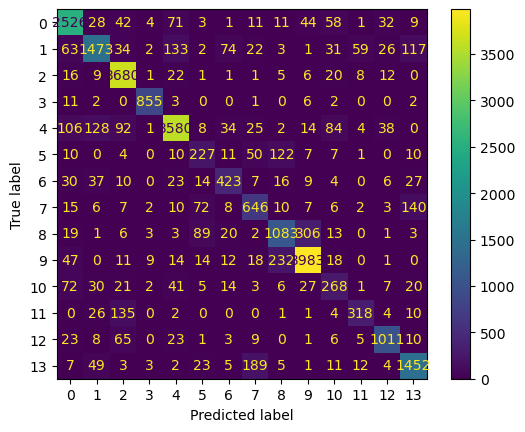

In [19]:
ConfusionMatrixDisplay.from_predictions(preds,labels)

In [15]:
model = resnet50(ResNet50_Weights.IMAGENET1K_V2)
model

/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/aayush/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
model.fc = nn.Linear(in_features=2048, out_features=14, bias=True) 

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
#criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.Adam(model.parameters(), lr=2e-4)
#exp_lr_scheduler = None
#model = model.to("mps")
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs=3)

Epoch 0/0
----------


100%|██████████| 31887/31887 [45:02<00:00, 11.80it/s] 


train Loss: 0.4423 Acc: 0.8550


100%|██████████| 4251/4251 [01:29<00:00, 47.28it/s]


val Loss: 0.5037 Acc: 0.8370

Training complete in 46m 34s
Best val Acc: 0.836951


In [20]:
torch.save(model.state_dict(), "res_net_50.pt")

In [22]:
model_2 = resnet50()
model_2.fc = nn.Linear(in_features=2048, out_features=14, bias=True)
model_2.load_state_dict(torch.load("res_net_50.pt"))
model_2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
model_2.to("mps")
preds,labels = evaluate(model_2)

 88%|████████▊ | 5593/6381 [01:49<00:14, 53.25it/s]

Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 284, in def

100%|██████████| 6381/6381 [02:05<00:00, 50.97it/s]


In [24]:
accuracy_score(preds,labels)

0.8421836422776973

In [25]:
f1_score(preds, labels, average="micro")

0.8421836422776973

In [26]:
f1_score(preds, labels, average="macro")

0.7624010789417495

In [27]:
print(classification_report(preds,labels))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2915
           1       0.81      0.74      0.78      1979
           2       0.96      0.91      0.94      4319
           3       0.96      0.95      0.95       896
           4       0.91      0.87      0.89      4118
           5       0.47      0.51      0.49       428
           6       0.74      0.65      0.69       693
           7       0.72      0.66      0.69      1067
           8       0.63      0.75      0.68      1260
           9       0.90      0.90      0.90      4373
          10       0.47      0.62      0.53       403
          11       0.44      0.83      0.57       217
          12       0.90      0.89      0.89      1162
          13       0.78      0.84      0.81      1687

    accuracy                           0.84     25517
   macro avg       0.75      0.78      0.76     25517
weighted avg       0.85      0.84      0.84     25517



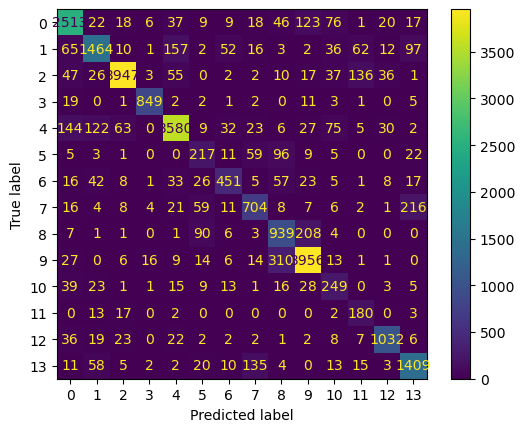

In [29]:
ConfusionMatrixDisplay.from_predictions(preds,labels)

In [3]:
model = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /Users/aayush/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:31<00:00, 11.1MB/s] 


In [4]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [5]:
model.heads.head = nn.Linear(in_features=768, out_features=14, bias=True) 

In [6]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=2e-4)
exp_lr_scheduler = None
model = model.to("mps")
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=2)

Epoch 0/1
----------


100%|██████████| 31887/31887 [5:31:40<00:00,  1.60it/s]   


train Loss: 0.8782 Acc: 0.7093


100%|██████████| 4251/4251 [16:07<00:00,  4.39it/s]


val Loss: 0.7504 Acc: 0.7552

Epoch 1/1
----------


100%|██████████| 31887/31887 [5:30:46<00:00,  1.61it/s]  


train Loss: 0.7485 Acc: 0.7500


100%|██████████| 4251/4251 [15:54<00:00,  4.46it/s]


val Loss: 0.7106 Acc: 0.7657

Training complete in 694m 32s
Best val Acc: 0.765661


In [29]:
torch.save(model.state_dict(), "ViT_B_16.pt")

In [32]:
model_2 = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
model_2.heads.head = nn.Linear(in_features=768, out_features=14, bias=True)
model_2.load_state_dict(torch.load("ViT_B_16.pt"))
model_2.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [33]:
model_2.to("mps")
preds,labels = evaluate(model_2)

 24%|██▎       | 1512/6381 [06:15<19:25,  4.18it/s]

Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 284, in def

100%|██████████| 6381/6381 [24:38<00:00,  4.31it/s]


In [34]:
accuracy_score(preds,labels)

0.7678802367049418

In [35]:
f1_score(preds, labels, average="micro")

0.7678802367049418

In [36]:
f1_score(preds, labels, average="macro")

0.6560295416103659

In [37]:
print(classification_report(preds,labels))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      3379
           1       0.74      0.68      0.71      1976
           2       0.88      0.93      0.90      3897
           3       0.91      0.97      0.94       825
           4       0.85      0.84      0.84      4001
           5       0.08      0.32      0.12       109
           6       0.52      0.42      0.47       752
           7       0.53      0.51      0.52      1023
           8       0.53      0.51      0.52      1559
           9       0.86      0.83      0.84      4548
          10       0.41      0.55      0.47       398
          11       0.45      0.74      0.56       246
          12       0.85      0.74      0.79      1312
          13       0.65      0.78      0.71      1492

    accuracy                           0.77     25517
   macro avg       0.65      0.68      0.66     25517
weighted avg       0.78      0.77      0.77     25517



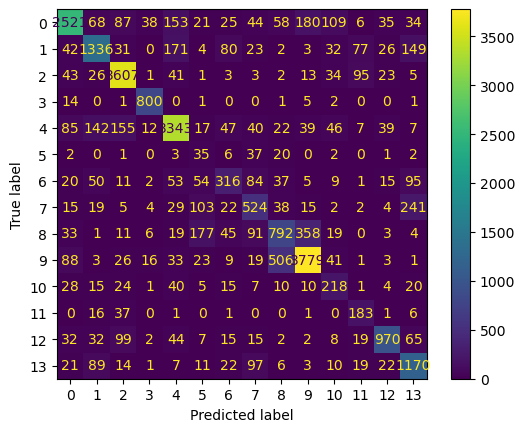

In [38]:
ConfusionMatrixDisplay.from_predictions(preds,labels)

In [39]:
eff = efficientnet_v2_s()
eff.classifier[1] = nn.Linear(in_features=1280, out_features=14, bias=True)
eff.load_state_dict(torch.load("efficient_net_small.pt"))
eff.eval()
eff.to("mps")
res = resnet50()
res.fc = nn.Linear(in_features=2048, out_features=14, bias=True)
res.load_state_dict(torch.load("res_net_50.pt"))
res.eval()
res.to("mps")
vit = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
vit.heads.head = nn.Linear(in_features=768, out_features=14, bias=True)
vit.load_state_dict(torch.load("ViT_B_16.pt"))
vit.eval()
vit.to("mps")

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [48]:
def get_voting_classes():
    full_labels = []
    full_preds = []
    iter_load = iter(dataloaders["test"])
    for i in tqdm(range(len(dataloaders["test"]))):
        try:
            inputs, labels = next(iter_load)
            inputs = inputs.to("mps")
            labels = labels.to("mps")
            with torch.set_grad_enabled(False):
                eff_outputs = eff(inputs)
                res_outputs = res(inputs)
                vit_outputs = vit(inputs)
                full_outputs = torch.add(nn.functional.softmax(eff_outputs,dim = 1),nn.functional.softmax(res_outputs,dim = 1))
                full_outputs = torch.add(full_outputs,nn.functional.softmax(vit_outputs,dim = 1))
                preds = torch.argmax(torch.div(full_outputs,3),dim = 1)
            full_preds.extend(preds.detach().cpu().numpy().tolist())
            full_labels.extend(labels.detach().cpu().numpy().tolist())
        except Exception as e:
            print(e)
            pass
    return full_preds, full_labels

In [49]:
preds,labels = get_voting_classes()

  4%|▍         | 260/6381 [01:19<29:57,  3.41it/s]

Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
  File "/Users/aayush/anaconda3/envs/final_project/lib/python3.10/site-packages/torchvision/datasets/folder.py", line 284, in def

100%|██████████| 6381/6381 [31:37<00:00,  3.36it/s]


In [50]:
accuracy_score(preds,labels)

0.652271034996277

In [51]:
f1_score(preds, labels, average="micro")

0.652271034996277

In [52]:
f1_score(preds, labels, average="macro")

0.5886157645821408

In [53]:
print(classification_report(preds,labels))

              precision    recall  f1-score   support

           0       0.97      0.38      0.54      7523
           1       0.82      0.51      0.63      2899
           2       0.73      0.96      0.83      3128
           3       0.93      0.96      0.95       856
           4       0.53      0.93      0.67      2213
           5       0.10      0.39      0.16       120
           6       0.37      0.78      0.50       284
           7       0.21      0.72      0.32       285
           8       0.28      0.66      0.39       640
           9       0.57      0.93      0.70      2694
          10       0.51      0.30      0.38       890
          11       0.53      0.78      0.63       277
          12       0.87      0.70      0.78      1428
          13       0.84      0.67      0.74      2280

    accuracy                           0.65     25517
   macro avg       0.59      0.69      0.59     25517
weighted avg       0.77      0.65      0.65     25517



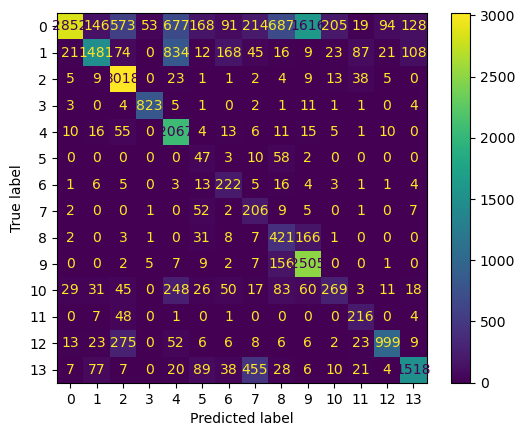

In [54]:
ConfusionMatrixDisplay.from_predictions(preds,labels)